In [1]:
import matplotlib.pyplot as plt
from roboflow import Roboflow
import supervision as sv
import numpy as np
import cv2
import math
import os

In [2]:
def display_images_grid(images, grid_size=(2, 2), figsize=(8, 8)):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    for i, ax in enumerate(axs):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')  
        else:
            ax.axis('off')  

    plt.tight_layout()
    plt.show()

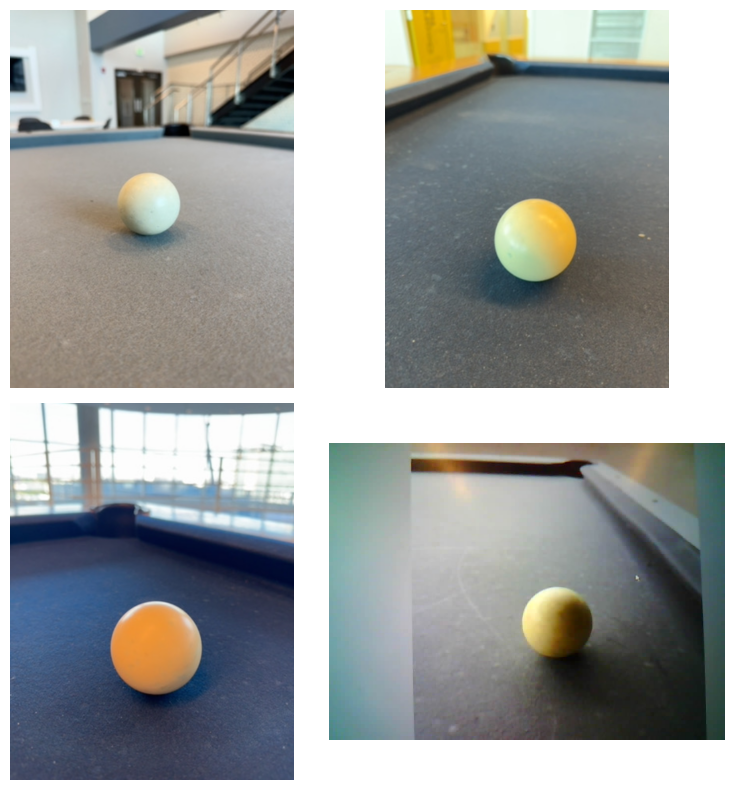

In [25]:
image_paths = ['Images/5.JPG', 'Images/6.JPG', 'Images/7.JPG', 'Images/10.JPG']
raw_images = []
resized_images = []

for path in image_paths:
    image = cv2.imread(path)
    raw_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    image_height, image_width = image.shape[:2]
    resized_image = cv2.resize(image, (500, int(500 * image_height / image_width)))
    resized_images.append(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  
    
display_images_grid(resized_images, grid_size=(2, 2))

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


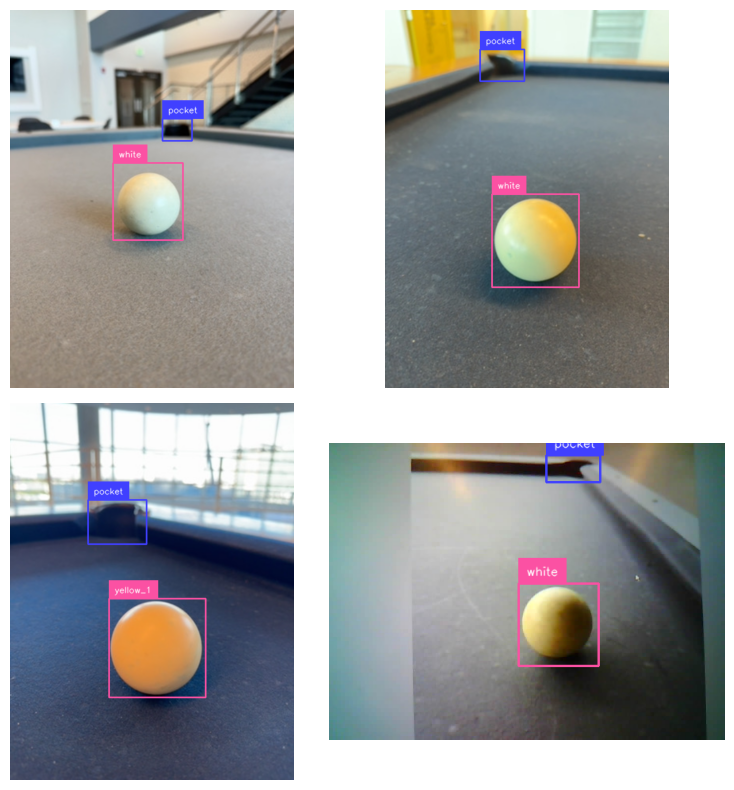

In [26]:
# for balls
rfb = Roboflow(api_key="cFhwJYkoxK6oElI6NL9a")
projectb = rfb.workspace().project("billiard-balls-kjqyt")
modelb = projectb.version(9).model

# for pockets
rfp = Roboflow(api_key="cFhwJYkoxK6oElI6NL9a")
projectp = rfp.workspace().project("pooltablepocket")
modelp = projectp.version(1).model

annotated_images = []

for i, resized_image in enumerate(resized_images):
    resized_image_path = f"resized_temp_{i}.jpg"
    cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

    resultb = modelb.predict(resized_image_path, confidence=0.5, overlap=0.2).json()
    resultp = modelp.predict(resized_image_path, confidence=0.5, overlap=0.5).json()
    
    detections = []
    confidence_scores = []
    labels = []

    for prediction in resultb["predictions"]:
        x, y, width, height = (
            prediction["x"],
            prediction["y"],
            prediction["width"],
            prediction["height"],
        )
        class_name = prediction["class"]
        confidence = prediction["confidence"]

        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(confidence)
        labels.append(class_name)
        
    for prediction in resultp["predictions"]:
        x, y, width, height = (
            prediction["x"],
            prediction["y"],
            prediction["width"],
            prediction["height"],
        )
        class_name = prediction["class"]
        confidence = prediction["confidence"]

        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(confidence)
        labels.append(class_name)

    detection_boxes = sv.Detections(
        xyxy=np.array(detections),  
        confidence=np.array(confidence_scores)  
    )
    detection_boxes.class_id = np.array([labels.index(label) for label in labels]) 
    
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = resized_image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detection_boxes)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detection_boxes, labels=labels)
    
    annotated_images.append(annotated_image)
    
    if os.path.exists(resized_image_path):
        os.remove(resized_image_path)

display_images_grid(annotated_images, grid_size=(2, 2))

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
Image 0: Angle between lines: -22.15 degrees
Image 1: Angle between lines: 10.72 degrees
Image 2: Angle between lines: 17.35 degrees
Image 3: Angle between lines: -5.36 degrees


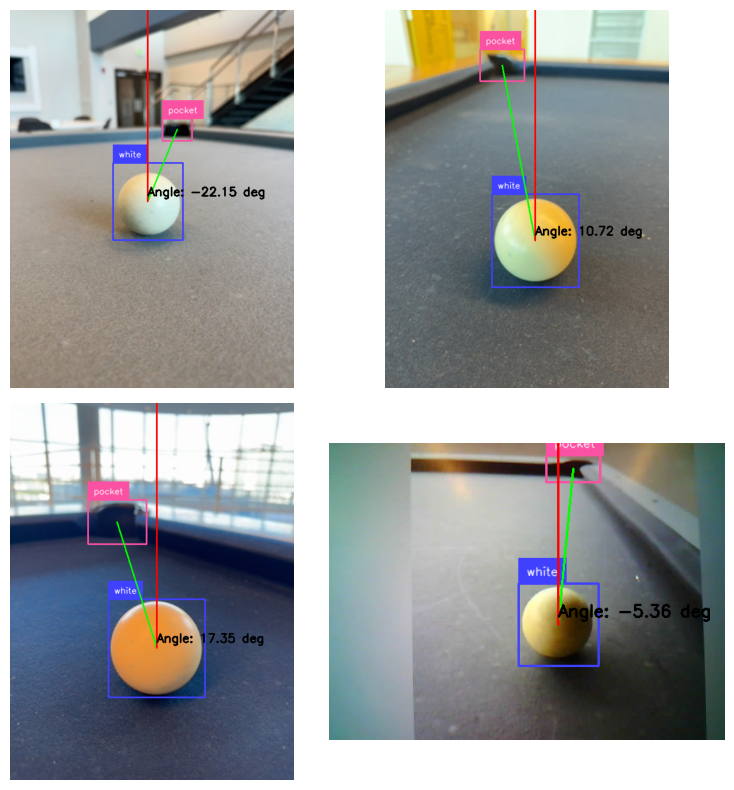

In [27]:
# for balls
rfb = Roboflow(api_key="cFhwJYkoxK6oElI6NL9a")
projectb = rfb.workspace().project("billiard-balls-kjqyt")
modelb = projectb.version(9).model

# for pockets
rfp = Roboflow(api_key="cFhwJYkoxK6oElI6NL9a")
projectp = rfp.workspace().project("pooltablepocket")
modelp = projectp.version(1).model

annotated_images = []
class_name_to_id = {"pocket": 0, "white": 1}

for i, resized_image in enumerate(resized_images):
    resized_image_path = f"resized_temp_{i}.jpg"
    cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

    resultb = modelb.predict(resized_image_path, confidence=0.2, overlap=0.5).json()
    resultp = modelp.predict(resized_image_path, confidence=0.5, overlap=0.5).json()
    
    detections = []
    confidence_scores = []
    labels = []
    pocket_centers = []
    white_centers = []

    for prediction in resultb["predictions"]:
        class_name = prediction["class"]
        if class_name != "white":
            continue  
        x, y, width, height = (
            prediction["x"],
            prediction["y"],
            prediction["width"],
            prediction["height"],
        )
        confidence = prediction["confidence"]

        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(confidence)
        labels.append(class_name)

        white_centers.append((x, y))

    for prediction in resultp["predictions"]:
        class_name = prediction["class"]
        if class_name != "pocket":
            continue  
        x, y, width, height = (
            prediction["x"],
            prediction["y"],
            prediction["width"],
            prediction["height"],
        )
        confidence = prediction["confidence"]

        x_min = int(x - width / 2)
        y_min = int(y - height / 2)
        x_max = int(x + width / 2)
        y_max = int(y + height / 2)

        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(confidence)
        labels.append(class_name)

        pocket_centers.append((x, y))

    if len(detections) == 0:
        print("No detections in image", i)
        annotated_images.append(resized_image)
        continue

    detection_boxes = sv.Detections(
        xyxy=np.array(detections),
        confidence=np.array(confidence_scores)
    )
    detection_boxes.class_id = np.array([class_name_to_id[label] for label in labels])
    
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = resized_image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detection_boxes)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detection_boxes, labels=labels)
    
    # Annotate lines and calculate angle
    if white_centers and pocket_centers:
        white_center = white_centers[0]
        pocket_center = pocket_centers[0]

        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                (int(pocket_center[0]), int(pocket_center[1])), (0, 255, 0), 2)

        vertical_end_point = (int(white_center[0]), 0)
        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                vertical_end_point, (255, 0, 0), 2)

        vector_line1_x = pocket_center[0] - white_center[0]
        vector_line1_y = pocket_center[1] - white_center[1]

        angle_rad = math.atan2(-vector_line1_x, -vector_line1_y)
        angle_deg = math.degrees(angle_rad)

        print(f"Image {i}: Angle between lines: {angle_deg:.2f} degrees")

        angle_text = f"Angle: {angle_deg:.2f} deg"
        cv2.putText(annotated_image, angle_text, (int(white_center[0]), int(white_center[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    else:
        print(f"Image {i}: White ball or pocket not detected")
    
    annotated_images.append(annotated_image)
    
    if os.path.exists(resized_image_path):
        os.remove(resized_image_path)

display_images_grid(annotated_images, grid_size=(2, 2))